In [1]:
# import all the needed stuff

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score, recall_score


In [2]:
# import the data

bankruptcy_df = pd.read_csv('data.csv')
#reading the first few to see if its okay. We can see that our bankruptcy is labelled in 1 and 0. (1 indicates bankrutpcy)
bankruptcy_df
#checking the shape of the data
n_features = bankruptcy_df.shape[1]

print(f"our X has {n_features} amount of features")
n_features = bankruptcy_df.shape[0]
#making sure that the features are actually correct
print(f"our Y has {n_features} amount of features")

# I get rid of constants
bankruptcy_df= bankruptcy_df.loc[:, bankruptcy_df.nunique() > 1]

# Drop the constant columns
bankruptcy_df = bankruptcy_df.drop(columns=[col for col in bankruptcy_df.columns if bankruptcy_df[col].nunique() == 1])

print(bankruptcy_df)

our X has 96 amount of features
our Y has 6819 amount of features
      Bankrupt?   ROA(C) before interest and depreciation before interest  \
0             1                                           0.370594          
1             1                                           0.464291          
2             1                                           0.426071          
3             1                                           0.399844          
4             1                                           0.465022          
...         ...                                                ...          
6814          0                                           0.493687          
6815          0                                           0.475162          
6816          0                                           0.472725          
6817          0                                           0.506264          
6818          0                                           0.493053          

       RO

In [3]:
#I check to see if there are any missing values but there is none.
print(bankruptcy_df.isnull().values.sum())
print(bankruptcy_df.isna().values.sum())


0
0


In [4]:
# We can see that the numbers are heavily skewed and this can cause some problems in relation to the accuracy of the model.
print(bankruptcy_df['Bankrupt?'].value_counts())

0    6599
1     220
Name: Bankrupt?, dtype: int64


In [5]:
#define x, y
target = "Bankrupt?"
X = bankruptcy_df.drop(columns=target)
y = bankruptcy_df[target]
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40)


In [6]:
# initialize kbest and fit it
"""""
from sklearn.feature_selection import f_classif
# Select the top 20 features using the F ANOVA test
selector = SelectKBest(score_func=f_classif, k=20)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get a list of the selected features
selected_feats = [columns for columns, mask in zip(X_train.columns, selector.get_support()) if mask]

# Fit a RF regression model using the selected features
modelrf = RandomForestClassifier()
modelrf.fit(X_train_selected, y_train)

# Predict the target values for the test set
anovafpredictions = modelrf.predict(X_test_selected)

# Calculate the accuracy score for the test set
accuracy = accuracy_score(y_test, anovafpredictions)

print("Accuracy:", accuracy)
result was = 0.96
"""
#our final feature selection method
RFEselect= RFE(RandomForestClassifier(n_estimators=100, random_state=40), n_features_to_select=20)

RFEselect.fit(X_train,y_train)

mask = RFEselect.get_support()

X_train_recursive = RFEselect.transform(X_train)
X_test_recursive = RFEselect.transform(X_test)

score = RandomForestClassifier().fit(X_train_recursive, y_train).score(X_test_recursive, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.973


In [7]:
# Create a list of selected feature names
selected_features = []
selected_features.insert(0, 'Bankrupt?')
# Iterate over the feature names and the corresponding values in the mask
for feature, is_selected in zip(bankruptcy_df.iloc[:,1:].keys(), mask):
  # If the feature is selected, add it to the list
  if is_selected:
    selected_features.append(feature)

In [8]:
#our selected features
print(selected_features)

['Bankrupt?', ' ROA(B) before interest and depreciation after tax', ' Non-industry income and expenditure/revenue', ' Interest-bearing debt interest rate', ' Net Value Per Share (B)', ' Persistent EPS in the Last Four Seasons', ' Per Share Net profit before tax (Yuan ¥)', ' Net Value Growth Rate', ' Quick Ratio', ' Interest Expense Ratio', ' Total debt/Total net worth', ' Borrowing dependency', ' Net profit before tax/Paid-in capital', ' Accounts Receivable Turnover', ' Cash/Current Liability', ' Working Capital/Equity', ' Net Income to Total Assets', " Net Income to Stockholder's Equity", ' Degree of Financial Leverage (DFL)', ' Interest Coverage Ratio (Interest expense to EBIT)', ' Equity to Liability']


In [9]:
# this is our fresh DF with 20 selected features according to the RFE
bankruptcy_freshdf = bankruptcy_df[selected_features] 
isinstance(bankruptcy_freshdf, pd.DataFrame)

bankruptcy_freshdf

,Bankrupt?,ROA(B) before interest and depreciation after tax,Non-industry income and expenditure/revenue,Interest-bearing debt interest rate,Net Value Per Share (B),Persistent EPS in the Last Four Seasons,Per Share Net profit before tax (Yuan ¥),Net Value Growth Rate,Quick Ratio,Interest Expense Ratio,...,Borrowing dependency,Net profit before tax/Paid-in capital,Accounts Receivable Turnover,Cash/Current Liability,Working Capital/Equity,Net Income to Total Assets,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,1,0.405750,0.302646,7.250725e-04,0.147950,0.169141,0.138736,0.000327,0.001208,0.629951,...,0.390284,0.137757,0.001814,1.473360e-04,0.721275,0.716845,0.827890,0.026601,0.564050,0.016469
1,1,0.516730,0.303556,6.470647e-04,0.182251,0.208944,0.169918,0.000443,0.004039,0.635172,...,0.376760,0.168962,0.001286,1.383910e-03,0.731975,0.795297,0.839969,0.264577,0.570175,0.020794
2,1,0.472295,0.302035,7.900790e-04,0.177911,0.180581,0.142803,0.000396,0.005348,0.629631,...,0.379093,0.148036,0.001495,5.340000e+09,0.742729,0.774670,0.836774,0.026555,0.563706,0.016474
3,1,0.457733,0.303350,4.490449e-04,0.154187,0.193722,0.148603,0.000382,0.002896,0.630228,...,0.379743,0.147561,0.001966,1.010646e-03,0.729825,0.739555,0.834697,0.026697,0.564663,0.023982
4,1,0.522298,0.303475,6.860686e-04,0.167502,0.212537,0.168412,0.000439,0.003727,0.636055,...,0.375025,0.167461,0.001449,6.804636e-04,0.732000,0.795016,0.839973,0.024752,0.575617,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.543230,0.303510,1.790179e-04,0.175045,0.216602,0.172102,0.000450,0.005457,0.631415,...,0.373823,0.171111,0.000690,5.071548e-03,0.736716,0.799927,0.840359,0.027064,0.566193,0.029890
6815,0,0.524172,0.303520,2.370237e-04,0.181324,0.216697,0.172780,0.000445,0.006741,0.631489,...,0.372505,0.171805,0.000655,4.727181e-03,0.734584,0.799748,0.840306,0.027009,0.566018,0.038284
6816,0,0.520638,0.303512,0.000000e+00,0.269521,0.210929,0.173232,0.000435,0.035112,0.630612,...,0.369637,0.172287,0.001510,8.821248e-02,0.737432,0.797778,0.840138,0.026791,0.565158,0.097649
6817,0,0.554045,0.303498,2.110211e-04,0.213392,0.228326,0.185584,0.000529,0.007256,0.630731,...,0.369649,0.182498,0.000716,7.133218e-03,0.736713,0.811808,0.841084,0.026822,0.565302,0.044009


In [10]:
# Logistic Regression

In [11]:
target = "Bankrupt?"
X_lgmodel = bankruptcy_freshdf.drop(columns=target)
y_lgmodel = bankruptcy_freshdf[target]


# balance our data with smoteen by putting it on the training data
smtn = SMOTEENN(random_state = 40)
#samples

X_train, X_test, y_train, y_test = train_test_split(X_lgmodel, y_lgmodel, random_state=40, test_size = 0.30)

X_sampled, y_sampled = smtn.fit_resample(X_train, y_train)

y_sampled.value_counts()
# Much more even numbers now


1    4485
0    4067
Name: Bankrupt?, dtype: int64

In [12]:
#scaling and transforming the data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_sampled)
X_test_std = scaler.transform(X_test)
#printed the transformed data to make sure it fits
print(X_test_std)
#Building the model
model = LogisticRegression(random_state = 40, max_iter = 10000)
model.fit(X_train_std, y_sampled)



[[-0.14187286  0.16446683 -0.11022857 ... -0.06836577 -0.052338
   1.19147951]
 [-0.08852419 -0.00531618 -0.11022857 ... -0.10112725 -0.51860125
  -0.42326773]
 [-0.25084037  0.12854323 -0.11022857 ... -0.0641504  -0.02336918
  -0.25591368]
 ...
 [ 0.06187366 -0.06277323 -0.11022857 ... -0.10437088 -0.61789684
  -0.41695051]
 [-0.84051347 -0.64624704 -0.11022857 ... -0.06314764 -0.01697401
  -0.45597476]
 [ 0.30080762  0.12378103 -0.11022857 ... -0.03831125  0.09937699
  -0.3252163 ]]


LogisticRegression(max_iter=10000, random_state=40)

In [13]:
#We can now use the model to make prections on our test data
y_pred = model.predict(X_test_std)

#We can use a confusion matrix to see the number of true positives, true negatives, false positives and false negatives.
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1624  352]
 [   4   66]]


In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90      1976
           1       0.16      0.94      0.27        70

    accuracy                           0.83      2046
   macro avg       0.58      0.88      0.59      2046
weighted avg       0.97      0.83      0.88      2046



In [15]:
#tuning the penalty paramter
param = [{'C': [0.1, 0.5, 1, 5, 10, 50, 100]}]
clf = GridSearchCV(LogisticRegression(solver='liblinear'), param, cv=5, scoring="accuracy")
clf.fit(X_train_std, y_sampled)
#print the scores
print("Best params: ", clf.best_params_)
print("accuracy :", clf.best_score_)



Best params:  {'C': 1}
accuracy : 0.8814310566988286


In [16]:

from sklearn.metrics import confusion_matrix
#predicting with the tuned gid
y_predtuned = clf.predict(X_test_std)
confusion_matrix2 = confusion_matrix(y_test, y_predtuned)
print(confusion_matrix2)


[[1625  351]
 [   4   66]]


In [17]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.82      0.90      1976
           1       0.16      0.94      0.27        70

    accuracy                           0.83      2046
   macro avg       0.58      0.88      0.59      2046
weighted avg       0.97      0.83      0.88      2046



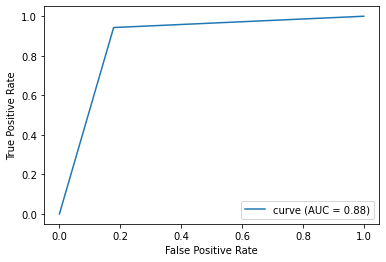

In [18]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_pred)
roc_auc = sklearn.metrics.auc(fpr, tpr)
display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='curve')

display.plot()
plt.show()

In [19]:
print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
#MAE is pretty close to 0 but this is not the metic we should only consider

#R2 is negative meaning we need to consider using other models, that are nonlinear.
print("\tR2 score:", r2_score(y_test, y_pred))


	Mean absolute error: 0.1739980449657869
	R2 score: -4.265876229034123


In [20]:
# KNN USING STRATIFIED SHUFFLE SPLIT INSTEAD

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
X_knn = bankruptcy_freshdf.drop(columns=target)
y_knn = bankruptcy_freshdf[target]

sss = StratifiedShuffleSplit(n_splits=5, random_state=40, test_size=0.3)

# we iterate over the splits, scale, define best params and train and predict.
for train_index, test_index in sss.split(X_knn, y_knn):
    X_train, X_test = X_knn.iloc[train_index], X_knn.iloc[test_index]
    y_train, y_test = y_knn.iloc[train_index], y_knn.iloc[test_index]
    
    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Define the parameter grid
    param_grid = {'n_neighbors': [2, 3, 5, 7, 9], 'p': [1, 2, 3]}
    
    # Create the grid search object
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1')
    
    # fit the training data 
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters and the best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(best_params, best_score)
    
    # Train the KNN model with the best parameters and scaled data
    grid_search.fit(X_train, y_train)
    
    #predictions
    KNN_predictions= grid_search.predict(X_test)
    print(classification_report(y_test, KNN_predictions))
    confusion_matrixRFF = confusion_matrix(y_test, KNN_predictions)
    print(confusion_matrixRFF)




{'n_neighbors': 3, 'p': 2} 0.3697134611420326
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1980
           1       0.50      0.26      0.34        66

    accuracy                           0.97      2046
   macro avg       0.74      0.62      0.66      2046
weighted avg       0.96      0.97      0.96      2046

[[1963   17]
 [  49   17]]
{'n_neighbors': 3, 'p': 2} 0.3331376264931082
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1980
           1       0.35      0.24      0.29        66

    accuracy                           0.96      2046
   macro avg       0.66      0.61      0.63      2046
weighted avg       0.95      0.96      0.96      2046

[[1950   30]
 [  50   16]]
{'n_neighbors': 3, 'p': 1} 0.3470084946500041
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1980
           1       0.52      0.23      0.32  

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
from sklearn.model_selection import GridSearchCV
X_rf = bankruptcy_freshdf.drop(columns=target)
y_rf = bankruptcy_freshdf[target]
#doing stratefied shuffle splits with 3 splits
sssRF = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=42)

for train_index, test_index in sssRF.split(X_rf, y_rf):
    X_train, X_test = X_rf.iloc[train_index], X_rf.iloc[test_index]
    y_train, y_test = y_rf.iloc[train_index], y_rf.iloc[test_index]

    param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
    }

    
    # Create the grid search
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring = 'f1')

    
    # fitting the training data to the grid
    grid_search.fit(X_train, y_train)
    
    # here are our best params
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Train the KNN model with the best parameters
    grid_search.fit(X_train, y_train)
    
    # lastly predictions
    RF_predictions= grid_search.predict(X_test)
    print(classification_report(y_test, RF_predictions))
    confusion_matrixRF = confusion_matrix(y_test, RF_predictions)
    print(confusion_matrixRF)
    



              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1980
           1       0.84      0.24      0.38        66

    accuracy                           0.97      2046
   macro avg       0.91      0.62      0.68      2046
weighted avg       0.97      0.97      0.97      2046

[[1977    3]
 [  50   16]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1980
           1       0.59      0.24      0.34        66

    accuracy                           0.97      2046
   macro avg       0.78      0.62      0.66      2046
weighted avg       0.96      0.97      0.96      2046

[[1969   11]
 [  50   16]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1980
           1       0.60      0.32      0.42        66

    accuracy                           0.97      2046
   macro avg       0.79      0.66      0.70      2046
weighted avg       0